# Training a model on forces and energies

In addition to the energy, machine learning models can also be used to model molecular forces.
These are $N_\mathrm{atoms} \times 3$ arrays describing the Cartesian force acting on each atom due to the overall (potential) energy.
They are formally defined as the negative gradient of the energy $E_\mathrm{pot}$ with respect to the nuclear positions $\mathbf{R}$
\begin{equation}
\mathbf{F}^{(\alpha)} = -\frac{\partial E_\mathrm{pot}}{\partial \mathbf{R}^{(\alpha)}},
\end{equation}
where $\alpha$ is the index of the nucleus.

The above expression offers a straightforward way to include forces in machine learning models by simply defining a model for the energy and taking the appropriate derivatives. 
The resulting model can directly be trained on energies and forces.
Moreover, in this manner energy conservation and the correct behaviour under rotations of the molecule is guaranteed.

Using forces in addition to energies to construct a machine learning model offers several advantages.
Accurate force predictions are important for molecular dynamics simulations, which will be covered in the subsequent tutorial.
Forces also encode a greater wealth of information than the energies. 
For every molecule, only one energy is present, while there are $3N_\mathrm{atoms}$ force entries.
This property, combined with the fact that reference forces can be computed at the same cost as energies, makes models trained on forces and energies very data efficient.

In the following, we will show how to train such force models and how to use them in practical applications.

## Preparing the data

The process of preparing the data is smilar to the tutorial on [QM9](tutorial_02_qm9.ipynb). We begin by importing all relevant packages and generating a directory for the tutorial experiments.

In [1]:
import schnetpack as spk
import os

forcetut = './forcetut'
if not os.path.exists(forcetut):
    os.makedirs(forcetut)

Next, the data needs to be loaded from a suitable dataset. 
For convenience, we use the MD17 dataset class provided in SchNetPack, which automtically downloads and builds suitable databases containing energies and forces for a range of small organic molecules. 
In this case, we use the ethanol molecule as an example.

In [2]:
from schnetpack.datasets import MD17

ethanol_data = MD17(os.path.join(forcetut,'ethanol.db'), molecule='ethanol')

For custom datasets, the data would have to be loaded via the SchNetPack `AtomsData` class. 
In this case, one needs to make sure, that the naming of properties is kept consistent. The `schnetpack.Properties` module provides standard names for a wide range of properties.
Here, we use the definitions provided with the `MD17` class.

In order to train force models, forces need to be included in the reference data.
Once the dataset was loaded, this can e.g. be checked by calling the `get_properties` function for sample entries. 
Here we look at the configuration with the index 0.
The function returns an ASE `Atoms` object and a dictionary containing the loaded properties:

In [3]:
atoms, properties = ethanol_data.get_properties(0)

print('Loaded properties:\n', *['{:s}\n'.format(i) for i in properties.keys()])

Loaded properties:
 energy
 forces
 _atomic_numbers
 _positions
 _cell
 _neighbors
 _cell_offset



As can be seen,  `energy` and `forces` are included in the properties dictionary. To have a look at the `forces` array and check whether it has the expected dimensions, we can call:

In [4]:
print('Forces:\n', properties[MD17.forces])
print('Shape:\n', properties[MD17.forces].shape)

Forces:
 tensor([[ 1.4517e+00,  6.0192e+00,  5.2068e-07],
        [ 1.7953e+01, -5.1624e+00,  3.4900e-07],
        [-4.0884e+00,  2.2590e+01,  3.3088e-06],
        [-1.1416e+00, -9.7469e+00,  7.6473e+00],
        [-1.1416e+00, -9.7469e+00, -7.6473e+00],
        [-2.4821e+00,  4.9335e+00,  4.3700e+00],
        [-2.4821e+00,  4.9335e+00, -4.3700e+00],
        [-5.5148e+00, -3.0207e+00, -8.9093e-09],
        [-2.4393e+00, -1.0838e+01, -6.0721e-08]])
Shape:
 torch.Size([9, 3])


The `atoms` object can e.g. be used to visualize the ethanol molecule:

In [5]:
from ase.visualize import view
view(atoms, viewer='x3d')

Next, the data is split into training (1000 points), test (500 points) and validation set (remainder) and data loaders are created. This is done in the same way as described in the [QM9 tutorial](tutorial_02_qm9.ipynb).

In [6]:
train, val, test = spk.train_test_split(
        data=ethanol_data,
        num_train=1000,
        num_val=500,
        split_file=os.path.join(forcetut, "split.npz"),
    )
    
train_loader = spk.AtomsLoader(train, batch_size=100, shuffle=True)
val_loader = spk.AtomsLoader(val, batch_size=100) 

Once again, we want to use the mean and standardeviation of the energies in the training data to precondition our model.
This only needs to be done for the energies, since the forces are obtained as derivatives and automatically capture the scale of the data.
Unlike in the case of QM9, the subtraction of atomic reference energies is not necessary, since only configurations of the same molecule are loaded.
All this can be done via the `get_statistics` function of the `AtomsLoader` class:

In [7]:
means, stddevs = train_loader.get_statistics(
    spk.datasets.MD17.energy, divide_by_atoms=True
)

print('Mean atomization energy / atom:      {:12.4f} [kcal/mol]'.format(means[MD17.energy][0]))
print('Std. dev. atomization energy / atom: {:12.4f} [kcal/mol]'.format(stddevs[MD17.energy][0]))

Mean atomization energy / atom:       -10799.5244 [kcal/mol]
Std. dev. atomization energy / atom:       0.4679 [kcal/mol]


## Building the model

After having prepared the data in the above way, we can now build and train the force model.
This is done in the same two steps as described in [QM9 tutorial](tutorial_02_qm9.ipynb):

1. Building the representation
2. Defining an output module

For the representation we can use the same `SchNet` layer as in the previous tutorial:

In [8]:
n_features = 128

schnet = spk.representation.SchNet(
    n_atom_basis=n_features,
    n_filters=n_features,
    n_gaussians=25,
    n_interactions=3,
    cutoff=5.,
    cutoff_network=spk.nn.cutoff.CosineCutoff
)

Since we want to model forces, the `Atomwise` output module needs to be adapted slightly.
We will still use one module to predict the energy, preconditioning with the mean and standard deviation per atom of the energy. 

However, since the forces should be described as the derivative of the energy, we have to indicate that the corresponding derviative of the model should be computed.
This is done by specifying `derivative=MD17.forces`, which also assigns the computed derivative to the property `MD17.forces`.
Since the forces are the negative gradient, we also need to enable `negative_dr=True`, which simply multipiies the derviative with -1.

In [9]:
energy_model = spk.atomistic.Atomwise(
    n_in=n_features,
    property=MD17.energy,
    mean=means[MD17.energy],
    stddev=stddevs[MD17.energy],
    derivative=MD17.forces,
    negative_dr=True
)

 Both modules are then combined to an `AtomisticModel`.

In [10]:
model = spk.AtomisticModel(representation=schnet, output_modules=energy_model)

## Training the model

To train the model on energies and forces, we need to update the loss function to include the latter. 
This combined loss function is:
\begin{equation}
\mathcal{L}(E_\mathrm{ref},\mathbf{F}_\mathrm{ref},E_\mathrm{pred}, \mathbf{F}_\mathrm{pred}) = \frac{1}{n_\text{train}} \sum_{n=1}^{n_\text{train}} \left[  \rho \left( E_\mathrm{ref} - E_\mathrm{pred} \right)^2  +  \frac{(1-\rho)}{3N_\mathrm{atoms}} \sum^{N_\mathrm{atoms}}_\alpha \left\| \mathbf{F}_\mathrm{ref}^{(\alpha)} - \mathbf{F}_\mathrm{pred}^{(\alpha)} \right\|^2 \right],
\end{equation}
where we take the predicted forces to be:
\begin{equation}
\mathbf{F}_\mathrm{pred}^{(\alpha)} = -\frac{\partial E_\mathrm{pred}}{\partial \mathbf{R}^{(\alpha)}}.
\end{equation}

We have introduced a parameter $\rho$ in order to control the tradeoff between energy and force loss.
By varying this parameter, the accuracy on energies and forces can be tuned.
Setting $\rho=0$ only forces are trained, while in the case of $\rho=1$ only energies are learned.
Using PyTorch, we can implement this loss function in the following way:

In [11]:
import torch

# tradeoff
rho_tradeoff = 0.1

# loss function
def loss(batch, result):
    # compute the mean squared error on the energies
    diff_energy = batch[MD17.energy]-result[MD17.energy]
    err_sq_energy = torch.mean(diff_energy ** 2)
    
    # compute the mean squared error on the forces
    diff_forces = batch[MD17.forces]-result[MD17.forces]
    err_sq_forces = torch.mean(diff_forces ** 2)

    # build the combined loss function
    err_sq = rho_tradeoff*err_sq_energy + (1-rho_tradeoff)*err_sq_forces
    
    return err_sq

Next, we procede in the same manner as in the [QM9 tutorial](tutorial_02_qm9.ipynb). First, we specify that the Adam optimizer from PyTorch should be used to train the model:

In [12]:
from torch.optim import Adam

# build optimizer
optimizer = Adam(model.parameters(), lr=5e-4)

Then, we construct the trainer hooks to monitor the training process and anneal the learning rate.
Since we also learn forces in addition to the energies, we include a corresponding metric into the logger.

In [13]:
# before setting up the trainer, remove previous training checkpoints and logs
%rm -rf ./forcetut/checkpoints
%rm -rf ./forcetut/log.csv

import schnetpack.train as trn

# set up metrics
metrics = [
    spk.metrics.MeanAbsoluteError(MD17.energy),
    spk.metrics.MeanAbsoluteError(MD17.forces)
]

# construct hooks
hooks = [
    trn.CSVHook(log_path=forcetut, metrics=metrics), 
    trn.ReduceLROnPlateauHook(
        optimizer, 
        patience=5, factor=0.8, min_lr=1e-6,
        stop_after_min=True
    )
]

Finally, we build the SchNetPack `Trainer` and pass the optimizer, loss function, hooks and data loaders.

In [14]:
trainer = trn.Trainer(
    model_path=forcetut,
    model=model,
    hooks=hooks,
    loss_fn=loss,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
)

We then train our model for 300 epochs, which should take approximately 10 minutes on a notebook GPU.

In [15]:
# check if a GPU is available and use a CPU otherwise
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

# determine number of epochs and train
n_epochs = 300
trainer.train(device=device, n_epochs=n_epochs)

Training will produce several files in the `model_path` directory, which is `forcetut` in our case.
The split is stored in `split.npz`. 
Checkpoints are written to `checkpoints` periodically, which can be used to restart training.
A copy of the best model is stored in `best_model`, which can directly be accessed using the `torch.load` function.
Since we specified the CSV logger, the training progress is saved to `log.csv`.

Using the CSV file, the training progress can be vizualized.
An example showing the evolution of the mean absolute errors (MAEs) during training is shown below.
Besides the `schnetpack.train.CSVHook`, it is also possible to use the `schnetpack.train.tensorboardHook`.
This makes it possible to monitor the training in real time with TensorBoard.

Validation MAE:
    energy:      0.414 kcal/mol
    forces:      1.099 kcal/mol/Å


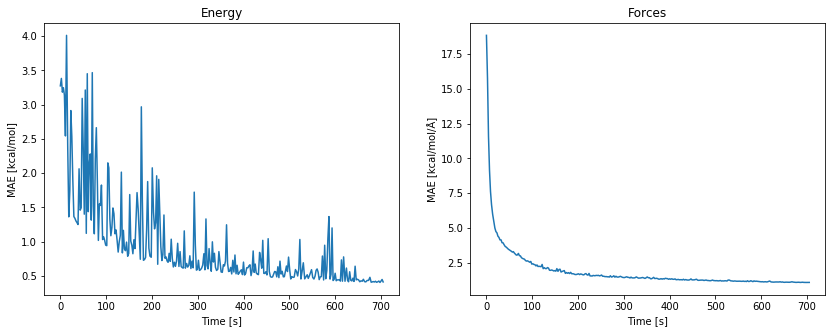

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from ase.units import kcal, mol

# Load logged results
results = np.loadtxt(os.path.join(forcetut, 'log.csv'), skiprows=1, delimiter=',')

# Determine time axis
time = results[:,0]-results[0,0]

# Load the validation MAEs
energy_mae = results[:,4]
forces_mae = results[:,5]

# Get final validation errors
print('Validation MAE:')
print('    energy: {:10.3f} kcal/mol'.format(energy_mae[-1]))
print('    forces: {:10.3f} kcal/mol/\u212B'.format(forces_mae[-1]))

# Construct figure
plt.figure(figsize=(14,5))

# Plot energies
plt.subplot(1,2,1)
plt.plot(time, energy_mae)
plt.title('Energy')
plt.ylabel('MAE [kcal/mol]')
plt.xlabel('Time [s]')

# Plot forces
plt.subplot(1,2,2)
plt.plot(time, forces_mae)
plt.title('Forces')
plt.ylabel('MAE [kcal/mol/\u212B]')
plt.xlabel('Time [s]')

plt.show()

It should be noted, that the model trained here is used exclusively for demonstrative purposes.
Accordingly, its size and the training time have been reduced significantly.
This puts strong constraints on the accuracy that can be obtained.
For practical applications, one would e.g. increase the number of features, the interaction layers, the learning rate schedule and train until convergence (removing the `n_epochs` keyword from the `trainer`).

SchNetPack also provides the script `schnetpack_md17.py`, which fully automates the whole training process for MD17 and comes with a series of reasonable default settings.

## Using the model

Since all models in SchNetPack are stored in the same way, we can use the trained force model in exactly the same manner as described in the [QM9 tutorial](tutorial_02_qm9.ipynb).

To load the model stored in the `best_model` file, we use the `torch.load` function.
It will automatically be moved to the device it was trained on.

In [17]:
best_model = torch.load(os.path.join(forcetut, 'best_model'))

To evaluate its performance on the test data, we use an adapted version of the loop introduced in the previous tutorial.
Since the MD17 dataset of ethanol contains approximately 550&thinsp;000 configurations, the full evaluation takes approximately 10 minutes on GPU.

In [18]:
test_loader = spk.AtomsLoader(test, batch_size=100)

energy_error = 0.0
forces_error = 0.0

for count, batch in enumerate(test_loader):    
    # move batch to GPU, if necessary
    batch = {k: v.to(device) for k, v in batch.items()}
    
    # apply model
    pred = best_model(batch)
    
    # calculate absolute error of energies
    tmp_energy = torch.sum(torch.abs(pred[MD17.energy] - batch[MD17.energy]))
    tmp_energy = tmp_energy.detach().cpu().numpy() # detach from graph & convert to numpy
    energy_error += tmp_energy
    
    # calculate absolute error of forces, where we compute the mean over the n_atoms x 3 dimensions
    tmp_forces = torch.sum(
        torch.mean(torch.abs(pred[MD17.forces] - batch[MD17.forces]), dim=(1,2))
    )
    tmp_forces = tmp_forces.detach().cpu().numpy() # detach from graph & convert to numpy
    forces_error += tmp_forces
    
    # log progress
    percent = '{:3.2f}'.format(count/len(test_loader)*100)
    print('Progress:', percent+'%'+' '*(5-len(percent)), end="\r")

energy_error /= len(test)
forces_error /= len(test)

print('\nTest MAE:')
print('    energy: {:10.3f} kcal/mol'.format(energy_error))
print('    forces: {:10.3f} kcal/mol/\u212B'.format(forces_error))

Progress: 99.98%
Test MAE:
    energy:      0.396 kcal/mol
    forces:      1.100 kcal/mol/Å


## Interface to ASE

As was shown in the [QM9 tutorial](tutorial_02_qm9.ipynb), one can also use the `AtomsConverter` to directly operate on ASE atoms objects.

Having access to molecular forces also makes it possible to perform a variety of different simulations.
The `SpkCalculator` offers a simple way to perform all computations available in the ASE package.
Below, we create an ASE calculator from the trained model and the previously generated `atoms` object (see [Preparing the data](#Preparing-the-data)).
One important point is, that the MD17 dataset uses kcal/mol and kcal/mol/&#8491; as units for energies and forces.
For the ASE interface, these need to be converted to the standard internal ASE units eV and eV/&#8491;.
This can be done by either passing the conversion factor or a string denoting the unit to the keywords `energy_units` and `force_units`. 

In [19]:
calculator = spk.interfaces.SpkCalculator(
    model=best_model,
    device=device,
    energy=MD17.energy,
    forces=MD17.forces,
    energy_units='kcal/mol',
    forces_units='kcal/mol/A'
)

atoms.set_calculator(calculator)

print('Prediction:')
print('energy:', atoms.get_total_energy())
print('forces:', atoms.get_forces())

Prediction:
energy: [-4215.326]
forces: [[ 4.8149731e-02  2.2211398e-01 -8.2710464e-08]
 [ 7.8540379e-01 -2.2908500e-01 -3.1016423e-08]
 [-9.7170897e-02  1.0150807e+00 -4.1355232e-08]
 [-2.6240392e-02 -4.0961695e-01  3.1710267e-01]
 [-2.6240392e-02 -4.0961662e-01 -3.1710231e-01]
 [-1.2042553e-01  2.2401318e-01  1.8506417e-01]
 [-1.2042536e-01  2.2401318e-01 -1.8506417e-01]
 [-3.1431168e-01 -1.4146599e-01 -2.2616142e-08]
 [-1.2873909e-01 -4.9543568e-01 -4.2001407e-09]]


Among the simulations which can be done by using ASE and a force model are geometry optimisation, normal mode analysis and simple molecular dynamics simulations.

The `AseInterface` of SchNetPack offers a convenient way to perform basic versions of these computations.
Only a file specifying the geometry of the molecule and a pretrained model are needed.

We will first generate a XYZ file containing an ethanol configuration:

In [20]:
from ase import io

# Generate a directory for the ASE computations
ase_dir = os.path.join(forcetut, 'ase_calcs')

if not os.path.exists(ase_dir):
    os.mkdir(ase_dir)

# Write a sample molecule
molecule_path = os.path.join( ase_dir, 'ethanol.xyz')
io.write(molecule_path, atoms, format='xyz')

The `AseInterface` is initialized by passing the path to the molecule, the model and a computation directory.
In addion, the computation device for the force model and how energies and forces are called in the output, as well as their units, need to be provided.

In [21]:
ethanol_ase = spk.interfaces.AseInterface(
    molecule_path,
    best_model,
    ase_dir,
    device,
    energy=MD17.energy,
    forces=MD17.forces,
    energy_units='kcal/mol',
    forces_units='kcal/mol/A'
)

### Geometry optimization

For some applications it is neccessary to relax a molecule to an energy minimum.
In order to perform this optimization of the molecular geometry, we can simply call

In [22]:
ethanol_ase.optimize(fmax=1e-4)

                Step[ FC]     Time          Energy          fmax
BFGSLineSearch:    0[  0] 14:04:31    -4215.326172        1.0197
BFGSLineSearch:    1[  2] 14:04:31    -4215.358887        0.6782
BFGSLineSearch:    2[  4] 14:04:31    -4215.370117        0.3471
BFGSLineSearch:    3[  6] 14:04:31    -4215.373535        0.2088
BFGSLineSearch:    4[  8] 14:04:31    -4215.376465        0.1770
BFGSLineSearch:    5[ 10] 14:04:31    -4215.377441        0.0837
BFGSLineSearch:    6[ 12] 14:04:31    -4215.377930        0.0413
BFGSLineSearch:    7[ 15] 14:04:31    -4215.377930        0.0323
BFGSLineSearch:    8[ 16] 14:04:31    -4215.378418        0.0184
BFGSLineSearch:    9[ 17] 14:04:31    -4215.378418        0.0042
BFGSLineSearch:   10[ 19] 14:04:31    -4215.378418        0.0022
BFGSLineSearch:   11[ 20] 14:04:31    -4215.378418        0.0016
BFGSLineSearch:   12[ 22] 14:04:31    -4215.378418        0.0028
BFGSLineSearch:   13[ 23] 14:04:31    -4215.378418        0.0022
BFGSLineSearch:   14[ 25]

Since we trained only a reduced model, the accuracy of energies and forces is not optimal and several steps are needed to optimize the geometry.

### Normal mode analysis

Once the geometry was optimized, normal mode frequencies can be obtained from the Hessian (matrix of second derivatives) of the molecule.
The Hessian is a measure of the curvature of the potential energy surface and normal mode frequencies are useful for determining, whether an optimization has reached a minimum.
Using the `AseInterface`, normal mode frequencies can be obtained via:

In [23]:
ethanol_ase.compute_normal_modes()

Writing ./forcetut/ase_calcs/normal_modes.eq.pckl
Writing ./forcetut/ase_calcs/normal_modes.0x-.pckl
Writing ./forcetut/ase_calcs/normal_modes.0x+.pckl
Writing ./forcetut/ase_calcs/normal_modes.0y-.pckl
Writing ./forcetut/ase_calcs/normal_modes.0y+.pckl
Writing ./forcetut/ase_calcs/normal_modes.0z-.pckl
Writing ./forcetut/ase_calcs/normal_modes.0z+.pckl
Writing ./forcetut/ase_calcs/normal_modes.1x-.pckl
Writing ./forcetut/ase_calcs/normal_modes.1x+.pckl
Writing ./forcetut/ase_calcs/normal_modes.1y-.pckl
Writing ./forcetut/ase_calcs/normal_modes.1y+.pckl
Writing ./forcetut/ase_calcs/normal_modes.1z-.pckl
Writing ./forcetut/ase_calcs/normal_modes.1z+.pckl
Writing ./forcetut/ase_calcs/normal_modes.2x-.pckl
Writing ./forcetut/ase_calcs/normal_modes.2x+.pckl
Writing ./forcetut/ase_calcs/normal_modes.2y-.pckl
Writing ./forcetut/ase_calcs/normal_modes.2y+.pckl
Writing ./forcetut/ase_calcs/normal_modes.2z-.pckl
Writing ./forcetut/ase_calcs/normal_modes.2z+.pckl
Writing ./forcetut/ase_calcs/nor

/home/mitx/anaconda3/envs/schnet_debug/lib/python3.6/site-packages/ase/vibrations/vibrations.py:355: ComplexWarning: Casting complex values to real discards the imaginary part
  fd.write('Mode #%d, f = %.1f%s cm^-1' % (n, f[n], c))


Imaginary frequencies indicate, that the geometry optimisation has not yet reached a minimum.
The `AseInterface` also creates an `normal_modes.xyz` file which can be used to visualize the vibrations with jmol.

### Molecular dynamics

Finally, it is also possible to basic run molecular dynamics simulations using this interface.
To do so, we first need to prepare the system, where we specify the simulation file.
This routine automatically initializes the velocities of the atoms to a random number corresponding to a certain average kinetic energy.

In [24]:
ethanol_ase.init_md(
    'simulation'
)

The actual simulation is performed by calling the function `run_md` with a certain number of steps:

In [25]:
ethanol_ase.run_md(1000)

During simulation, energies and geometries are logged to `simulation.log` and `simulation.traj`, respectively.

We can for example visualize the evolution of the systems total and potential energies as

Average temperature:     170.79 K


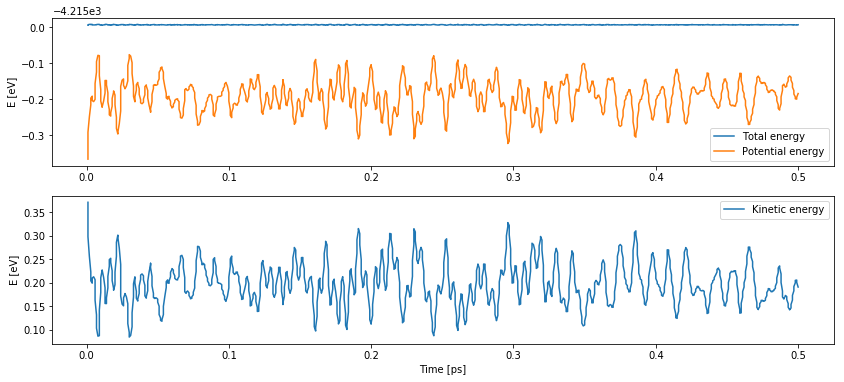

In [26]:
# Load logged results
results = np.loadtxt(os.path.join(ase_dir, 'simulation.log'), skiprows=1)

# Determine time axis
time = results[:,0]

# Load energies
energy_tot = results[:,1]
energy_pot = results[:,2]
energy_kin = results[:,3]

# Construct figure
plt.figure(figsize=(14,6))

# Plot energies
plt.subplot(2,1,1)
plt.plot(time, energy_tot, label='Total energy')
plt.plot(time, energy_pot, label='Potential energy')
plt.ylabel('E [eV]')
plt.legend()

plt.subplot(2,1,2)
plt.plot(time, energy_kin, label='Kinetic energy')
plt.ylabel('E [eV]')
plt.xlabel('Time [ps]')
plt.legend()

temperature = results[:,4]
print('Average temperature: {:10.2f} K'.format(np.mean(temperature)))

plt.show()

As can be seen, the potential and kinetic energies fluctuate, while the total energy (sum of potential and kinetic energy) remains approximately constant.
This is a good demonstration for the energy conservation obtained by modeling forces as energy derivatives.
Unfortunately, this also means that energy conservation is not a sufficient measure for the quality of the potential.

However, frequently one is interested in simulations where the system is coupled to an external heat bath.
This is the same as saying that we wish to keep the average kinetic energy of the system and hence temperature close a certain value.
Currently the average temperature only depends on the random velocities drawn during the initialization of the dynamics.
Keeping a constant temperature average be achived by using a so-called thermostat.
In the `AseInterface`, simulations with a thermostat (to be precise a Langevin thermostat) can be carried out by providing the `temp_bath` keyword.
A simulation with e.g. the target temperature of 300K is performed via:

In [27]:
ethanol_ase.init_md(
    'simulation_300K',
    temp_bath=300,
    reset=True
)
ethanol_ase.run_md(20000)

We can now once again plot total and potential energies.
Instead of the kinetic energy, we now plot the temperature (both quantities are directly related).

Average temperature:     263.97 K


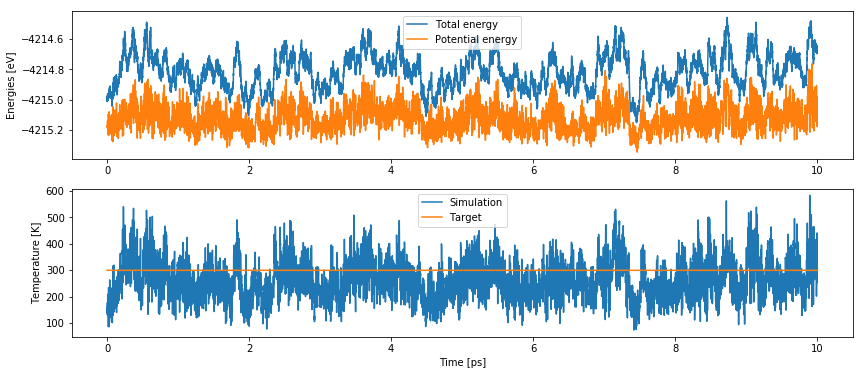

In [28]:
# Load logged results
results = np.loadtxt(os.path.join(ase_dir, 'simulation_300K.log'), skiprows=1)

# Determine time axis
time = results[:,0]
#0.02585
# Load energies
energy_tot = results[:,1]
energy_pot = results[:,2]

# Construct figure
plt.figure(figsize=(14,6))

# Plot energies
plt.subplot(2,1,1)
plt.plot(time, energy_tot, label='Total energy')
plt.plot(time, energy_pot, label='Potential energy')
plt.ylabel('Energies [eV]')
plt.legend()

# Plot Temperature
temperature = results[:,4]

# Compute average temperature
print('Average temperature: {:10.2f} K'.format(np.mean(temperature)))

plt.subplot(2,1,2)
plt.plot(time, temperature, label='Simulation')
plt.ylabel('Temperature [K]')
plt.xlabel('Time [ps]')
plt.plot(time, np.ones_like(temperature)*300, label='Target')
plt.legend()
plt.show()

Since our molecule is now subjected to external influences via the thermostat the total energy is no longer conserved.
However, the simulation temperature now fluctuates near to the requested 300K.
This can also be seen by computing the temperature average over time, which is now close to the desired value in contrast to the previous simulation.

## Summary

In this tutorial, we have trained a SchNet model on energies and forces using the MD17 ethanol dataset as an example. 
We have then evaluated the performance of the model and performed geometry optimisation, normal mode analysis and basic molecular dynamic simulations using the SchNetPack ASE interface.

While these simulations can already be useful for practical applications, SchNetPack also comes with its own molecular dynamics package.
This package makes it possible to run efficient simulations on GPU and also offers access to advanced techniques, such as ring polymer dynamics.
In the next tutorial, we will cover how to perform molecular dynamics simulations directly with SchNetPack.